In [10]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();

  Activating project at `~/Documents/eth_courses/notebooks/dynamics/julia/demos/quad_3d`


In [776]:
using ModelingToolkit
using OrdinaryDiffEq, DiffEqCallbacks
using LinearAlgebra
using StaticArrays
using Rotations

using GLMakie
using BenchmarkTools
GLMakie.activate!(inline=true)

In [777]:
function plot_position_attitude(sol::ODESolution)
    fig = Figure(resolution = (1000, 700))
    
    ax1 = Axis(fig[1, 1], title="x Position")
    ax2 = Axis(fig[1, 2], title="y Position")
    ax3 = Axis(fig[1, 3], title="z Position")
    
    # ax2 = Axis(fig[1, 2], title="Velocity")
    
    ax4 = Axis(fig[2, 1], title="Attitude (quaternion)")
    ax5 = Axis(fig[2, 2], title="Angular velocity")
    
    lines!(ax1, sol.t, sol[plant.r[1]])
    lines!(ax2, sol.t, sol[plant.r[2]])
    lines!(ax3, sol.t, sol[plant.r[3]])

    # lines!(ax2, sol.t, sol[plant.ṙ[1]])
    # lines!(ax2, sol.t, sol[plant.ṙ[2]])
    # lines!(ax2, sol.t, sol[plant.ṙ[3]])
    
    lines!(ax4, sol.t, sol[plant.q[1]])
    lines!(ax4, sol.t, sol[plant.q[2]])
    lines!(ax4, sol.t, sol[plant.q[3]])
    lines!(ax4, sol.t, sol[plant.q[4]])

    lines!(ax5, sol.t, sol[plant.ω[1]])
    lines!(ax5, sol.t, sol[plant.ω[2]])
    lines!(ax5, sol.t, sol[plant.ω[3]])
    
    display(fig)
end

plot_position_attitude (generic function with 1 method)

## Full attitude dynamics 

In [778]:
function quaternion_integrator(q0, ω, dt)
    q_exp = exp( QuatRotation(0, ω[1]*dt/2, ω[2]*dt/2, ω[3]*dt/2, false).q);
    q_exp_q = QuatRotation(q_exp.s, q_exp.v1, q_exp.v2, q_exp.v3, false)
    
    q1 = q_exp_q * q0;

    return q1
end

quaternion_integrator (generic function with 1 method)

In [888]:
function RigidBody(;name, m, I_xx,I_yy,I_zz)

    # translation
    @variables t (r(t))[1:3]=0 (ṙ(t))[1:3]=0 
    
    # rotation
    @variables (q(t))[1:4]=0 (ω(t))[1:3]=0 
    
    # external force, torque
    @variables (f(t))[1:3]=0 (τ(t))[1:3] 
    
    @parameters m=m I_xx=I_xx I_yy=I_yy I_zz=I_yy
    
    D = Differential(t)
    
    translational_kinematics = D.(r) .~ ṙ
    
    translational_dynamics = D.(ṙ) .~ f / m
    
    rotation_kinematics = D.(q) .~ 0  # implemented in callback
    
    rotation_dynamics = [
        D.(ω[1]) .~ (τ[1] - (I_yy-I_zz )*ω[2]*ω[3]) / I_xx ,
        D.(ω[2]) .~ (τ[2] - (I_xx-I_zz )*ω[1]*ω[3]) / I_yy ,
        D.(ω[3]) .~ (τ[3] - (I_yy-I_xx )*ω[1]*ω[2]) / I_zz ,
        ]
    
    # eqns = vcat(translational_kinematics,translational_dynamics, rotation_kinematics, rotation_dynamics, external_force ,external_torque)
    eqns = vcat(translational_kinematics,translational_dynamics, rotation_kinematics, rotation_dynamics)
    
    ODESystem(eqns, t; name)
    
    # sys = structural_simplify(model);

end

RigidBody (generic function with 1 method)

In [886]:
motor_thrust_to_body_thrust(l,k_τ) = [1 1 1 1; 
                            0 l 0 -l;
                            -l 0 l 0;
                            k_τ -k_τ k_τ -k_τ]

body_thrust_to_motor_thrust(l,k_τ) = inv(motor_thrust_to_body_thrust(l,k_τ))

body_thrust_to_motor_thrust (generic function with 1 method)

In [895]:
function Quadcopter(;name,l, k_τ, m, I_xx,I_yy,I_zz)

    # translation
    @variables t (r(t))[1:3]=0 (ṙ(t))[1:3]=0 
    
    # rotation
    @variables (q(t))[1:4]=0 (ω(t))[1:3]=0 
 
    # motor thrusts
    @variables t (f(t))[1:4]=0 

    params = @parameters l=l k_τ=k_τ g=9.81
    
    @named rb = RigidBody(;name=:rb, m=m ,I_xx=I_xx, I_yy=I_yy, I_zz=I_yy);

    # forces
    f_x = 0
    f_y = 0
    f_z = f[1] + f[2] + f[3] + f[4]

    # moments
    τ_x = l*(f[2] - f[4])
    τ_y = l*(f[3] - f[1])
    τ_z = k_τ*(f[1] - f[2] + f[3] - f[2])

    # transform from body to intertial frame
    R_IB = QuatRotation(q[1], q[2], q[3], q[4], false)
    f_net = R_IB * [f_x; f_y; f_z] - [0;0; g] 
    
    thrust_eqn = rb.f .~ f_net
    torque_eqn  = rb.τ .~ [τ_x; τ_y; τ_z]


    # set the quadcopter pose to equal the rigidbody pose
    eqn3 = r .~ rb.r
    eqn4 = ṙ .~ rb.ṙ
    eqn5 = q .~ rb.q
    eqn6 = ω .~ rb.ω
    
    eqns = vcat(thrust_eqn, torque_eqn, eqn3,eqn4,eqn5,eqn6)
    
    # connect the subsystems
    ODESystem(eqns, t, systems=[rb]; name)
        
end

Quadcopter (generic function with 1 method)

## Controller

### Zero order hold for digital controller

In [896]:
# force control input to be constant over sampling time, actual control law applied inside callback
function Controller_Zero_Order_Hold(;name)
    sts = @variables t U(t)[1:4]=0 (R(t))[1:3]=0

    # define operators
    D = Differential(t)

    eqn1 = D.(U) .~ 0 
    eqn2 = D.(R) .~ 0 

    eqns = vcat(eqn1, eqn2)
    
    ODESystem(eqns, t; name)
end

Controller_Zero_Order_Hold (generic function with 1 method)

### Callback (for quaternion integration)

In [982]:
include("pid.jl")

callback_params = (;allocation_matrix=body_thrust_to_motor_thrust(0.7,0.0035),
    reference_generator=reference_generator)

function digital_controller(int; params = callback_params)

    # extract the state
    r =  @view int.u[1:3]
    ṙ =  @view int.u[4:6]
    q0_vec = @view int.u[7:10]
    ω = @view int.u[11:13]

    dt = 0.01
    m = 1.0
    g = 9.81

    # quaternion integration ------------------------------------------------
    q0 = QuatRotation(q0_vec, false);
    q1 = quaternion_integrator(q0, ω, dt)

    # set attitude
    int.u[7:10] = [q1.q.s, q1.q.v1, q1.q.v2, q1.q.v3]

    # controller ------------------------------------------------

    allocation_matrix = params.allocation_matrix

    # get reference 
    R = reference_generator(int.t)

    e_x = R[1] - r[1]
    e_y = R[2] - r[2]
    e_z = R[3] - r[3]

    # control laws 

    # x position controller
    q_ref = pid_controller(x_pos_pid; e=e_x, umin=-100, umax=100 ) / g
    
    # y position controller
    p_ref = -pid_controller(y_pos_pid; e=e_y, umin=-100, umax=100 ) / g

    # z position controller
    f_net = m*(g + pid_controller(z_pos_pid; e=e_z, umin=-100, umax=100 ))

     # attitude controller

    # convert quaternion attitude representation to euler angles 
    r,q,p = Rotations.params(RotZYX(q1))
    
    e_p = p_ref - p
    e_q = q_ref - q
    
    τ_x = pid_controller(roll_pid; e=e_p, umin=-25, umax=25 )
    τ_y = pid_controller(pitch_pid; e=e_q, umin=-25, umax=25 )
    τ_z = 0

    # f_net = 9.81
    # τ_x, τ_y= 0,0

    motor_thrusts = allocation_matrix * [f_net; τ_x; τ_y; τ_z]

    # set the control input
    c_index = 14
    int.u[c_index:c_index+3] .= motor_thrusts

    R_IB = q1
    f_net_I = R_IB*[0;0;f_net]

    # @show R_IB.q
    # @show f_net_I

    # @show e_x,e_y,e_z 
    # # @show p, q
    # # @show p_ref, q_ref
    # @show e_p,e_q
    # @show  τ_x, τ_y
    # @show motor_thrusts 
    # println("")    
end 

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true);

## Reference generator

In [988]:
function reference_generator(t)

    r = 0.5    # circle radius 
    ω = 0.2    # angular velocity

    z_0 = 1

    # circular trajectory 
    # x_ref = r*sin(ω*t)
    # y_ref = r*sin(ω*t)
    # z_ref = 1.0

    x_ref = 1
    y_ref = 2.
    z_ref = 1.0
    
    return [x_ref, y_ref, z_ref]
end

reference_generator (generic function with 1 method)

## System building

In [980]:

@named plant = Quadcopter(;name=:quad1, l=0.7, k_τ=0.0035, m=1.0, I_xx=0.003, I_yy=0.003, I_zz=0.02);
@named controller = Controller_Zero_Order_Hold()

# motor thrusts
eqn1 = controller.U .~ plant.f

eqns = vcat(eqn1)

# connect the subsystems
@named model = ODESystem(eqns,
    systems=[plant, controller])

sys = structural_simplify(model);


eval(f_net) = Num[2((q(t))[1]*(q(t))[3] + (q(t))[2]*(q(t))[4])*((f(t))[1] + (f(t))[2] + (f(t))[3] + (f(t))[4]), 2((q(t))[3]*(q(t))[4] - (q(t))[1]*(q(t))[2])*((f(t))[1] + (f(t))[2] + (f(t))[3] + (f(t))[4]), ((q(t))[1]^2 + (q(t))[4]^2 - ((q(t))[2]^2) - ((q(t))[3]^2))*((f(t))[1] + (f(t))[2] + (f(t))[3] + (f(t))[4]) - g]


  1.230655 seconds (799.69 k allocations: 54.576 MiB, 3.39% gc time)


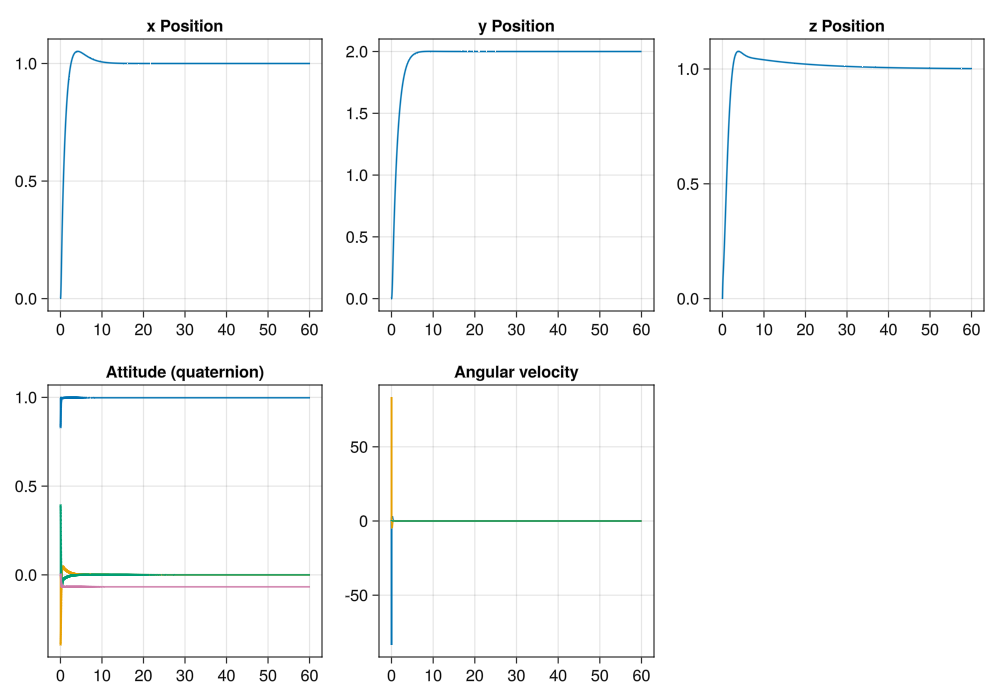

GLMakie.Screen(...)

In [989]:
# sim
tspan = (0.0, 60.0)

# controllers
x_pos_pid =  PID(;kp=3.5, ki=0.00, kd=7, k_aw=0.0, Ts=0.01)
y_pos_pid =  PID(;kp=3.5, ki=0.00, kd=7, k_aw=0.0, Ts=0.01)
z_pos_pid =  PID(;kp=1.7, ki=0.1, kd=2.0, k_aw=0.0, Ts=0.01)

roll_pid =  PID(;kp=0.05, ki=0.00, kd=0.07, k_aw=0.0, Ts=0.01)
pitch_pid =  PID(;kp=0.05, ki=0.00, kd=0.07, k_aw=0.0, Ts=0.01)

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true);

# initial conditions
r₀ = [0.,0.,0.]
ṙ₀ = [0.,0.,0.]
# q₀ = [1., 0.,0.,0.]
q₀ = QuatRotation(RotZYX(0.0, 0.0, 0.0)) # (yaw, pitch, roll)
ω₀ = [0.0,0.0,0.]

# initial conditions
X₀ = [collect(plant.rb.r.=> r₀);
    collect(plant.rb.ṙ.=> ṙ₀);
    collect(plant.rb.q.=> [q₀.q.s, q₀.q.v1, q₀.q.v2, q₀.q.v3]);
    collect(plant.rb.ω.=> ω₀)]

prob = ODEProblem(sys, X₀, tspan, callback=control_callback) 
@time sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8 , save_everystep = false);

plot_position_attitude(sol)

In [960]:
let

f_net = 9.81
R_IB = QuatRotation(RotZYX(0.0, 0.5, 0))
    
R_IB*[0;0;f_net]
R_IB.q
end

Quaternions.QuaternionF64(0.9689124217106447, 0.0, 0.2474039592545229, 0.0)